In [1]:
import re
import scipy
from numpy import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf 
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dense

from sklearn.svm import LinearSVC
from sklearn import preprocessing,svm
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, log_loss, precision_recall_fscore_support

Using TensorFlow backend.


### Read Files

In [2]:
train_df=pd.read_csv('UNSW_2018_IoT_Botnet_Final_10_best_Training.csv')
test_df=pd.read_csv('UNSW_2018_IoT_Botnet_Final_10_best_Testing.csv')

In [3]:
train_df

,pkSeqID,proto,saddr,sport,daddr,dport,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack,category,subcategory
0,3142762,udp,192.168.100.150,6551,192.168.100.3,80,251984,1.900363,100,0.000000,4,2.687519,100,0.000000,0.494549,4.031619,1,DDoS,UDP
1,2432264,tcp,192.168.100.150,5532,192.168.100.3,80,256724,0.078003,38,3.856930,3,3.934927,100,0.000000,0.256493,4.012924,1,DDoS,TCP
2,1976315,tcp,192.168.100.147,27165,192.168.100.3,80,62921,0.268666,100,2.974100,3,3.341429,100,0.000000,0.294880,3.609205,1,DDoS,TCP
3,1240757,udp,192.168.100.150,48719,192.168.100.3,80,99168,1.823185,63,0.000000,4,3.222832,63,0.000000,0.461435,4.942302,1,DoS,UDP
4,3257991,udp,192.168.100.147,22461,192.168.100.3,80,105063,0.822418,100,2.979995,4,3.983222,100,0.000000,1.002999,4.994452,1,DDoS,UDP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2934812,1132803,udp,192.168.100.149,56044,192.168.100.5,80,253370,0.016992,100,4.082509,4,4.102515,100,0.000000,0.243473,4.124047,1,DoS,UDP
2934813,3384621,udp,192.168.100.150,21546,192.168.100.3,80,231693,1.922317,100,0.000000,4,2.718527,100,0.000000,0.490800,4.090534,1,DDoS,UDP
2934814,775893,udp,192.168.100.149,30897,192.168.100.5,80,158616,2.112228,100,0.000000,4,2.110766,100,0.000000,0.207444,4.332615,1,DoS,UDP
2934815,443484,tcp,192.168.100.147,36904,192.168.100.7,80,179855,0.000000,100,0.000000,3,0.000000,100,0.000000,0.162130,0.000000,1,DoS,TCP


In [4]:
test_df

,pkSeqID,proto,saddr,sport,daddr,dport,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack,category,subcategory
0,792371,udp,192.168.100.150,48516,192.168.100.3,80,175094,0.226784,100,4.100436,4,4.457383,100,0.000000,0.404711,4.719438,1,DoS,UDP
1,2056418,tcp,192.168.100.148,22267,192.168.100.3,80,143024,0.451998,100,3.439257,1,3.806172,100,0.225077,0.401397,4.442930,1,DDoS,TCP
2,2795650,udp,192.168.100.149,28629,192.168.100.3,80,167033,1.931553,73,0.000000,4,2.731204,100,0.000000,0.407287,4.138455,1,DDoS,UDP
3,2118009,tcp,192.168.100.148,42142,192.168.100.3,80,204615,0.428798,56,3.271411,1,3.626428,100,0.000000,0.343654,4.229700,1,DDoS,TCP
4,303688,tcp,192.168.100.149,1645,192.168.100.5,80,40058,2.058381,100,0.000000,3,1.188407,100,0.000000,0.135842,4.753628,1,DoS,TCP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733700,1571905,udp,192.168.100.148,17412,192.168.100.6,80,168162,1.743940,39,0.000000,4,3.020449,39,0.000000,0.224603,4.043432,1,DoS,UDP
733701,2787099,udp,192.168.100.147,932,192.168.100.3,80,158482,0.694618,65,3.002272,4,3.905409,100,0.000000,0.875121,4.691634,1,DDoS,UDP
733702,2255382,tcp,192.168.100.149,47980,192.168.100.3,80,79841,1.744651,53,0.000000,1,2.464288,100,0.278496,0.472773,3.802142,1,DDoS,TCP
733703,588946,tcp,192.168.100.147,25096,192.168.100.7,80,63165,0.000000,100,0.000000,3,0.000000,100,0.000000,0.070461,0.000000,1,DoS,TCP


# Preprocessing

### Merge Files

In [5]:
main_df=pd.concat([train_df,test_df])

In [6]:
del(train_df)
del(test_df)

### Select columns

In [7]:
ndf=main_df[['seq', 'stddev',
       'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP',
       'drate', 'srate', 'max','attack', 'category']]

In [8]:
ndf.head()

,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack,category
0,251984,1.900363,100,0.000000,4,2.687519,100,0.0,0.494549,4.031619,1,DDoS
1,256724,0.078003,38,3.856930,3,3.934927,100,0.0,0.256493,4.012924,1,DDoS
2,62921,0.268666,100,2.974100,3,3.341429,100,0.0,0.294880,3.609205,1,DDoS
3,99168,1.823185,63,0.000000,4,3.222832,63,0.0,0.461435,4.942302,1,DoS
4,105063,0.822418,100,2.979995,4,3.983222,100,0.0,1.002999,4.994452,1,DDoS


### Filter Milicious Column

In [9]:
nndf=ndf[ndf['attack']==1]
nndf.shape

(3668045, 12)

In [10]:
del(main_df)

### split features & class

In [11]:
X_data=nndf.iloc[:,:-2]
y_data=nndf.iloc[:,-2]

### scaling

In [12]:
min_max_scaler = preprocessing.MinMaxScaler()
X_data= min_max_scaler.fit_transform(X_data)

# GAN

In [13]:
def generate_latent_points(latent_dim, n_samples):
    x_input = random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [14]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    y = np.zeros((n_samples, 1))
    
    return X, y

In [15]:
# generate n real samples with class labels; We randomly select n samples from the real data
def generate_real_samples(n):
    X = X_data
    y = y_data
    return X, y

In [16]:
def define_generator(latent_dim, n_outputs=10):
    model = Sequential()
    model.add(Dense(20, input_dim=10, activation='tanh'))
    model.add(Dense(60, input_dim=20, activation='tanh'))
    model.add(Dense(80, input_dim=60, activation='tanh'))
    model.add(Dense(90, input_dim=80, activation='tanh'))
    model.add(Dense(10, input_dim=90, activation='linear'))
    return model


    

In [17]:
def define_discriminator(n_inputs=10):
    model = Sequential()
    model.add(Dense(20, input_dim=10, activation='tanh'))
    model.add(Dense(60, input_dim=20, activation='tanh'))
    model.add(Dense(80, input_dim=60, activation='tanh'))
    model.add(Dense(90, input_dim=80, activation='tanh'))
    model.add(Dense(1, input_dim=90, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [18]:
discriminator1 = define_discriminator(9)
discriminator1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_2 (Dense)              (None, 60)                1260      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4880      
_________________________________________________________________
dense_4 (Dense)              (None, 90)                7290      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 91        
Total params: 13,741
Trainable params: 13,741
Non-trainable params: 0
_________________________________________________________________


In [19]:
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [20]:
# create a line plot of loss for the gan and save to file
def plot_history(d_hist, g_hist):
    # plot loss
    plt.subplot(1, 1, 1)
    plt.plot(d_hist, label='d')
    plt.plot(g_hist, label='gen')
    plt.show()
    plt.close()

### train model

In [21]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=100, n_batch=128, n_eval=200):
    # determine half the size of one batch, for updating the  discriminator
    half_batch = int(n_batch / 2)
    d_history = []
    g_history = []
    # manually enumerate epochs
    for epoch in range(n_epochs):
    
        # prepare real samples
        x_real, y_real = generate_real_samples(half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator
        d_loss_real, d_real_acc = d_model.train_on_batch(x_real, y_real)
        d_loss_fake, d_fake_acc = d_model.train_on_batch(x_fake, y_fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = np.ones((n_batch, 1))
        # update the generator via the discriminator's error
        g_loss_fake = gan_model.train_on_batch(x_gan, y_gan)
        print('>%d, d1=%.3f, d2=%.3f d=%.3f g=%.3f' % (epoch+1, d_loss_real, d_loss_fake, d_loss,  g_loss_fake))
        d_history.append(d_loss)
        g_history.append(g_loss_fake)
    plot_history(d_history, g_history)
    g_model.save('trained_generated_model.h5')

>1, d1=0.629, d2=0.739 d=0.684 g=0.691
>2, d1=0.428, d2=0.773 d=0.600 g=0.686
>3, d1=0.311, d2=0.767 d=0.539 g=0.682
>4, d1=0.234, d2=0.776 d=0.505 g=0.648
>5, d1=0.178, d2=0.731 d=0.455 g=0.650
>6, d1=0.139, d2=0.802 d=0.470 g=0.618
>7, d1=0.111, d2=0.830 d=0.471 g=0.637
>8, d1=0.093, d2=0.857 d=0.475 g=0.612
>9, d1=0.082, d2=0.828 d=0.455 g=0.592
>10, d1=0.076, d2=0.830 d=0.453 g=0.610
>11, d1=0.074, d2=0.855 d=0.464 g=0.584
>12, d1=0.075, d2=0.895 d=0.485 g=0.605
>13, d1=0.080, d2=0.815 d=0.448 g=0.617
>14, d1=0.090, d2=0.841 d=0.465 g=0.653
>15, d1=0.103, d2=0.799 d=0.451 g=0.698
>16, d1=0.122, d2=0.756 d=0.439 g=0.736
>17, d1=0.148, d2=0.647 d=0.398 g=0.762
>18, d1=0.179, d2=0.675 d=0.427 g=0.817
>19, d1=0.216, d2=0.653 d=0.434 g=0.852
>20, d1=0.258, d2=0.617 d=0.438 g=0.897
>21, d1=0.300, d2=0.603 d=0.452 g=0.916
>22, d1=0.340, d2=0.597 d=0.468 g=0.868
>23, d1=0.373, d2=0.640 d=0.507 g=0.811
>24, d1=0.402, d2=0.719 d=0.561 g=0.735
>25, d1=0.425, d2=0.761 d=0.593 g=0.730
>26, d1=0

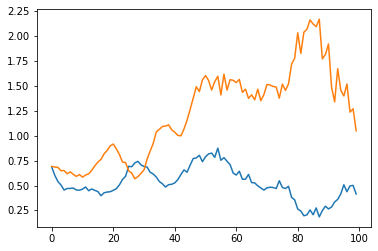

In [22]:
# size of the latent space
latent_dim = 10
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)

### load model

In [38]:
import keras
import tensorflow as tf
from keras.models import load_model
model =tf.keras.models.load_model('trained_generated_model.h5')

model.compile(loss='binary_crossentropy', optimizer='adam')

### Generate samples

In [39]:
latent_points = generate_latent_points(10, 750)
X = model.predict(latent_points)
X.shape

(750, 10)

In [40]:
data_fake = pd.DataFrame(data=X,  columns=['seq', 'stddev',
       'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP',
       'drate', 'srate', 'max'])

data_fake.head()

,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max
0,1.645930,0.840491,2.088738,1.124760,0.373873,-0.898381,1.309552,0.436898,0.336842,-0.032825
1,-0.224831,0.397244,0.751797,-2.125969,-0.771141,0.770777,-0.435992,-1.515242,-0.213287,0.660939
2,-1.044114,-0.539605,-0.375513,1.926106,0.189807,-1.019616,2.327802,2.139241,1.051636,-0.361869
3,4.079103,1.007976,3.422555,5.398277,1.645355,-0.244076,1.665839,3.882542,-0.430755,-0.304942
4,-1.779276,0.331207,-1.256551,-3.554392,-1.667898,-0.687445,0.353365,-3.420722,1.383849,1.012490


### Add class

In [41]:
data_fake['attack'] = 1
data_fake.head()

,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack
0,1.645930,0.840491,2.088738,1.124760,0.373873,-0.898381,1.309552,0.436898,0.336842,-0.032825,1
1,-0.224831,0.397244,0.751797,-2.125969,-0.771141,0.770777,-0.435992,-1.515242,-0.213287,0.660939,1
2,-1.044114,-0.539605,-0.375513,1.926106,0.189807,-1.019616,2.327802,2.139241,1.051636,-0.361869,1
3,4.079103,1.007976,3.422555,5.398277,1.645355,-0.244076,1.665839,3.882542,-0.430755,-0.304942,1
4,-1.779276,0.331207,-1.256551,-3.554392,-1.667898,-0.687445,0.353365,-3.420722,1.383849,1.012490,1


### save generated samples

In [42]:
data_fake.to_csv("fake_data.csv", index=False)

# Prediction

### Read Generated Samples

In [43]:
fake_df=pd.read_csv('fake_data.csv')
fake_df.head()

,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack
0,1.645930,0.840491,2.088738,1.124760,0.373873,-0.898381,1.309552,0.436898,0.336842,-0.032825,1
1,-0.224831,0.397244,0.751797,-2.125969,-0.771141,0.770777,-0.435992,-1.515242,-0.213287,0.660939,1
2,-1.044114,-0.539605,-0.375513,1.926106,0.189807,-1.019616,2.327802,2.139241,1.051636,-0.361869,1
3,4.079104,1.007976,3.422555,5.398277,1.645355,-0.244076,1.665839,3.882542,-0.430755,-0.304942,1
4,-1.779276,0.331207,-1.256551,-3.554392,-1.667898,-0.687445,0.353365,-3.420721,1.383849,1.012490,1


### preprocessing

In [44]:
fake_df.columns

Index(['seq', 'stddev', 'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean',
       'N_IN_Conn_P_DstIP', 'drate', 'srate', 'max', 'attack'],
      dtype='object')

In [45]:
ndf = fake_df[['seq', 'stddev',
       'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP',
       'drate', 'srate', 'max','attack']]

In [46]:
X=ndf.iloc[:,:-1]
y=ndf.iloc[:,-1]

### load RF model and get prediction

In [47]:
import pickle
 
# load the model from disk
filename = 'trained_RF_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X, y)
print(result)

0.944


In [48]:
y_pred = loaded_model.predict(X)

In [49]:
y_pred = list(map(int, y_pred))

In [50]:
conf_mat = confusion_matrix(y, y_pred)

Confusion matrix, without normalization


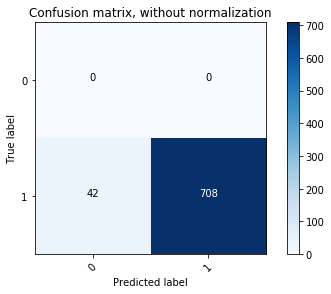

In [51]:
import itertools
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix


class_names = ['0', '1']
plt.figure()
generate_confusion_matrix(conf_mat, classes=class_names, title='Confusion matrix, without normalization')
plt.show()

### load dense model and get prediction

In [52]:
import keras
import tensorflow as tf
from keras.models import load_model
model =tf.keras.models.load_model('trained_dense_model.h5')

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

score = model.evaluate(X, y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 97.60%
